# HMC benchmark in BAT

In [1]:
using Random, LinearAlgebra, Statistics, StatsBase, ValueShapes
using StatsFuns, Distributions, ForwardDiff
using IntervalSets, ArraysOfArrays, Plots
using HDF5

In [2]:
using Revise
using BAT

┌ Info: Precompiling BAT [c0cd4b16-88b7-57fa-983b-ab80aecada7e]
└ @ Base loading.jl:1278


## Simple Gaussian

### Setup

In [3]:
# Simulation
N = 100
mu = 0.0
sigma = 1.0

# Sampling
iters = 2000
iters_warmup = 1000
chains = 4

# Benchmarking
Ntrials = 1000;

In [4]:
mutable struct input_data
    N::Int64
    mu::Float64
    sigma::Float64
    y::Array{Float64, 1}
end

In [5]:
output = rand(Normal(mu, sigma), N)
data = input_data(N, mu, sigma, output)
nothing

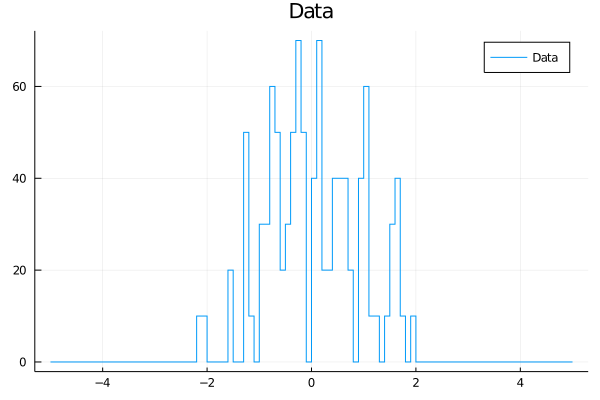

In [6]:
hist = append!(Histogram(-5:0.1:5), output)

plot(normalize(hist, mode=:density),
    st = :steps, label = "Data",
    title = "Data")

### Model

In [7]:
function likelihood(data) 
    
    params -> begin
        
        ll_value = sum(logpdf.(Normal(params.mu, data.sigma), data.y))
        
        return LogDVal(ll_value)
    end
end

prior = NamedTupleDist(
    mu = Normal(0.0, 50.0)
);

posterior = PosteriorDensity(likelihood(data), prior);

### Sampler

In [8]:
metric = DiagEuclideanMetric()
integrator = LeapfrogIntegrator(0.0)
proposal = NUTS(:MultinomialTS, :ClassicNoUTurn)
adaptor = StanHMCAdaptor(0.8, iters_warmup)

ahmc_sampler = AHMC(metric, ForwardDiff, integrator, proposal, adaptor)

AHMC
  metric: DiagEuclideanMetric DiagEuclideanMetric()
  gradient: Module ForwardDiff
  integrator: LeapfrogIntegrator
  proposal: NUTS
  adaptor: StanHMCAdaptor


### Benchmark

In [10]:
exec_time = Array{Float64}(undef, Ntrials)
sample_mean = Array{Float64}(undef, Ntrials)
neff = Array{Float64}(undef, Ntrials)
step_size = Array{Float64}(undef, (chains, Ntrials))
tree_depth = Array{Float64}(undef, (chains, Ntrials, iters));

for n in 1:Ntrials
    data.y = rand(Normal(data.mu, data.sigma), data.N)
    posterior = PosteriorDensity(likelihood(data), prior);
    exec_time[n] = @elapsed s, c = bat_sample(posterior, (iters, chains), 
        ahmc_sampler)
    sample_mean[n] = mean(unshaped.(s))[1]
    neff[n] = bat_eff_sample_size(unshaped.(s)).result[1]
    for j in 1:chains
        start = ((j-1) * iters) + 1 
        step_size[j,n] = c[j].transition.stat.step_size
        tree_depth[j,n,:] = s.info.tree_depth[start:start+(iters-1)]
    end
end

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/fran/projects/odsl/BAT/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/fran/projects/odsl/BAT/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/fran/projects/odsl/BAT/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin burnin of 4 MCMC chain(s).
└ @ BAT /Users/fran/projects/odsl/BAT/BAT.jl/src/samplers/mcmc/ahmc/only_burnin_tuner.jl:70
┌ Info: MCMC burnin cycle 1 finished, 4 chains, 4 converged, 4 tuned.
└ @ BAT /Users/fran/projects/odsl/BAT/BAT.jl/src/samplers/mcmc/ahmc/only_burnin_tuner.jl:99
┌ Info: MCMC burnin of 4 chains successful after 1 cycle(s).
└ @ BAT /Users/fran/projects/odsl/BAT/BAT.jl/src/samplers/mcmc/ahmc/only_burnin_tuner.jl:103
┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/fran/projects/odsl/BAT/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying t

### Results

In [11]:
h5open("output/hmc_bat_benchmark.h5", "w") do file
    file["sample_mean"] = sample_mean
    file["exec_time"] = exec_time
    file["neff"] = neff
    file["step_size"] = step_size
    file["tree_depth"] = tree_depth
    file["chains"] = chains
    file["iters"] = iters
    file["warmup_iters"] = iters_warmup
    file["Ntrials"] = Ntrials
    file["N"] = N
end
nothing